### Lab 7 & 8: Event selection optimization & Pseudo-experiment data analysis
- Haikun Xue

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

from astropy.table import Table
import pickle
import pandas as pd

plt.style.use('ggplot')
plt.tight_layout();

<Figure size 640x480 with 0 Axes>

### Lab 7

In [3]:
infile = open ("dati/higgs_250_500.pkl",'rb')
higgs_dic = pickle.load(infile)
infile.close()

infile = open ("dati/qcd_250_500.pkl",'rb')
qcd_dic = pickle.load(infile)
infile.close()

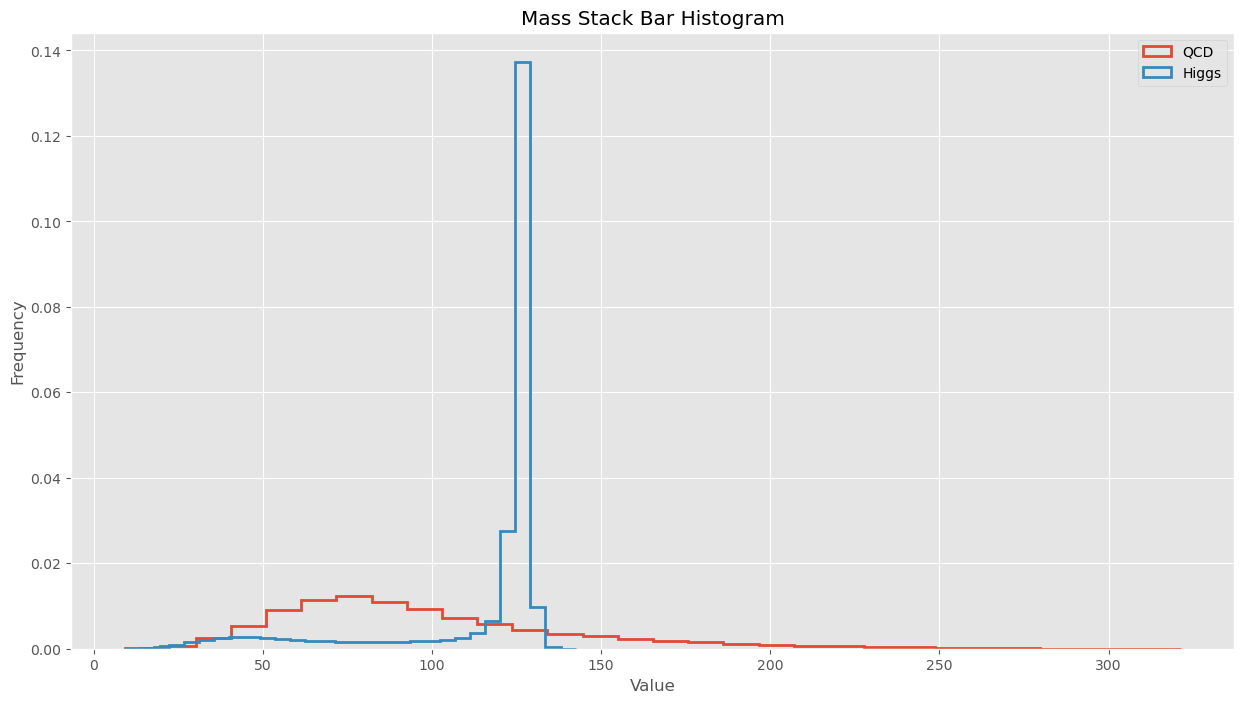

In [4]:
plt.rcParams["figure.figsize"] = (15,8)

fig, ax = plt.subplots(1,1)

ax.hist(qcd_dic["mass"], 30, histtype='step', linewidth = 2, density = True, stacked=True, label = "QCD")
ax.hist(higgs_dic["mass"], 30, histtype='step',linewidth = 2,density = True, stacked=True, label = "Higgs")
ax.set_title('Mass Stack Bar Histogram');
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend();

#### 1)  
With expected yields $N_{Higgs} = 100$ and $N_{QCD} = 20000$,   
the significant is equivalent to asking what is the probability (in $\sigma$) of  
detecting 20100 with a Poisson distribution with mean 20000.

In [5]:
N_Higgs = 100
N_QCD = 20000
prob = stats.poisson.cdf(N_QCD +N_Higgs,N_QCD)
stats.norm.ppf(prob)

0.7112259282313185

0.711 $\sigma$ is not very significant.   
Using the approximation, $N_{Higgs}/ \sqrt {N_{QCD}}$, we get:

In [6]:
N_Higgs/ np.sqrt(N_QCD)

0.7071067811865475

As $\sqrt{variance} = \sigma$, the approximation evaluates  
how many sigma away the signal is at in a normal distribution.  
The approximation works in this case , as for large variance,  
the Poisson distribution is almost the same as a normal distribution.

#### 2)    
After observing the above graph,   
we can attempt a few appropriate cuts.  
First, mass cut between 100 and 150:

In [7]:
# This function takes 2 dataframes, and return cut versions based on given parameters
def cut2(qcd_data,higgs_data, prop, upper = float('inf'), lower = float('-inf') , pri = True):
    qcd_cut = qcd_data[prop][(qcd_data[prop] < upper) & (qcd_data[prop] > lower)]
    higgs_cut = higgs_data[prop][(higgs_data[prop] < upper) & (higgs_data[prop] > lower)]
    N_Higgs_cut = N_Higgs* len(higgs_cut)/len(higgs_dic)
    N_QCD_cut = N_QCD* len(qcd_cut)/len(qcd_dic)
    if pri:
        print("After the cut, N_Higgs = {}, N_QCD = {}".format(N_Higgs_cut, N_QCD_cut))
    prob = stats.poisson.cdf(N_Higgs_cut+ N_QCD_cut,N_QCD_cut)
    result = stats.norm.ppf(prob)
    if pri:
        print("The expected significance is: {0:.2f} sigma".format(result))
    return (qcd_cut,higgs_cut,result)

In [8]:
r = cut2(qcd_dic,higgs_dic,'mass',150,100)

After the cut, N_Higgs = 84.947, N_QCD = 5181.0
The expected significance is: 1.17 sigma


Then, mass cut between 110 and 140:

In [9]:
r = cut2(qcd_dic,higgs_dic,'mass',140,110)

After the cut, N_Higgs = 82.788, N_QCD = 3015.2
The expected significance is: 1.50 sigma


Then, mass cut between 120 and 130:

In [10]:
r = cut2(qcd_dic,higgs_dic,'mass',130,120)

After the cut, N_Higgs = 75.847, N_QCD = 980.2
The expected significance is: 2.41 sigma


The last cut has very good significance, as we are cutting away 95% of the background data  
and only 25% of Higgs data. 

In [11]:
qcd_mass_cut = qcd_dic[(qcd_dic['mass'] < 130) & (qcd_dic['mass'] > 120)]
higgs_mass_cut = higgs_dic[(higgs_dic['mass'] < 130) & (higgs_dic['mass'] > 120)]

In [12]:
keys = higgs_dic.keys()

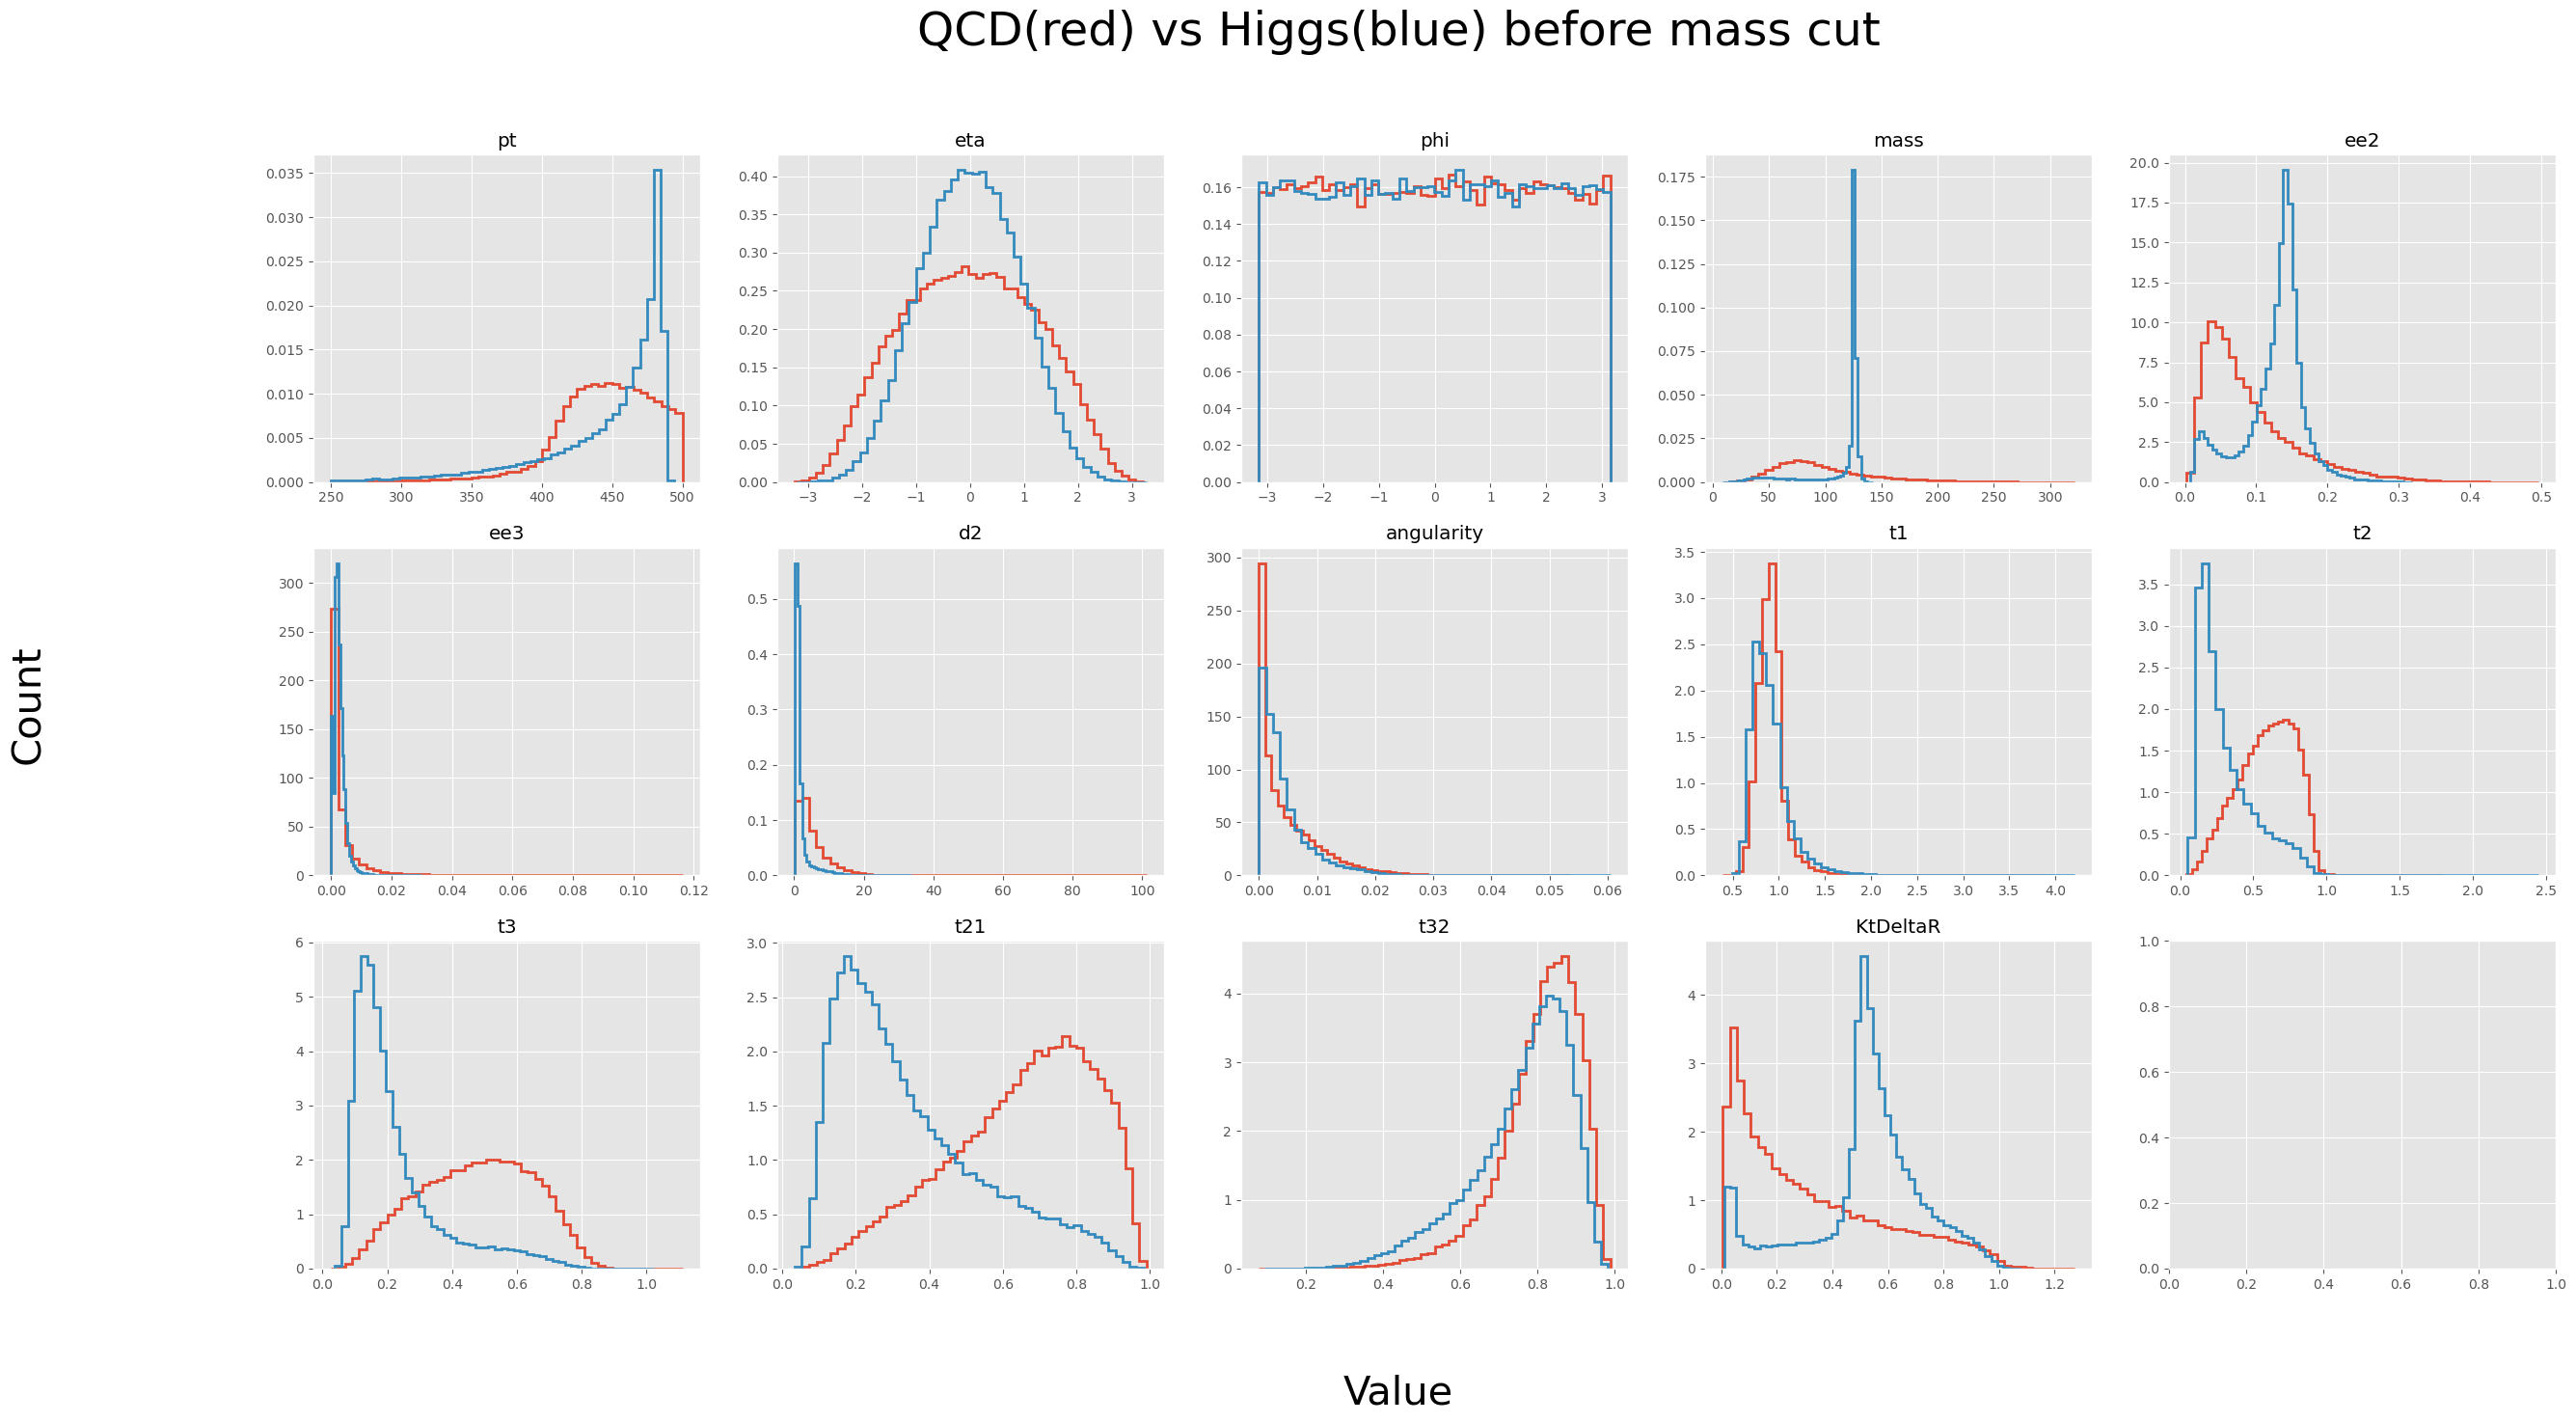

In [13]:
plt.rcParams["figure.figsize"] = (30,15)

fig, ax = plt.subplots(3,5)
bin_Size = 50
fig.suptitle('QCD(red) vs Higgs(blue) before mass cut', fontsize = 35)
fig.supxlabel('Value',fontsize = 30)
fig.supylabel('Count',fontsize = 30)

for i, val in enumerate (keys):
    ax_x = int(i/5)
    ax_y = i%5
    ax[ax_x,ax_y].hist(qcd_dic[val], histtype='step',density=True,bins = bin_Size, linewidth = 2)
    ax[ax_x,ax_y].hist(higgs_dic[val], histtype='step',density=True,bins = bin_Size, linewidth = 2)
    ax[ax_x,ax_y].set_title('{}'.format(val));

Before event selection, QCD and Higgs are clearly distiniguishable in  
mass, ee2, t2, t3, t21 and KtDelaR.

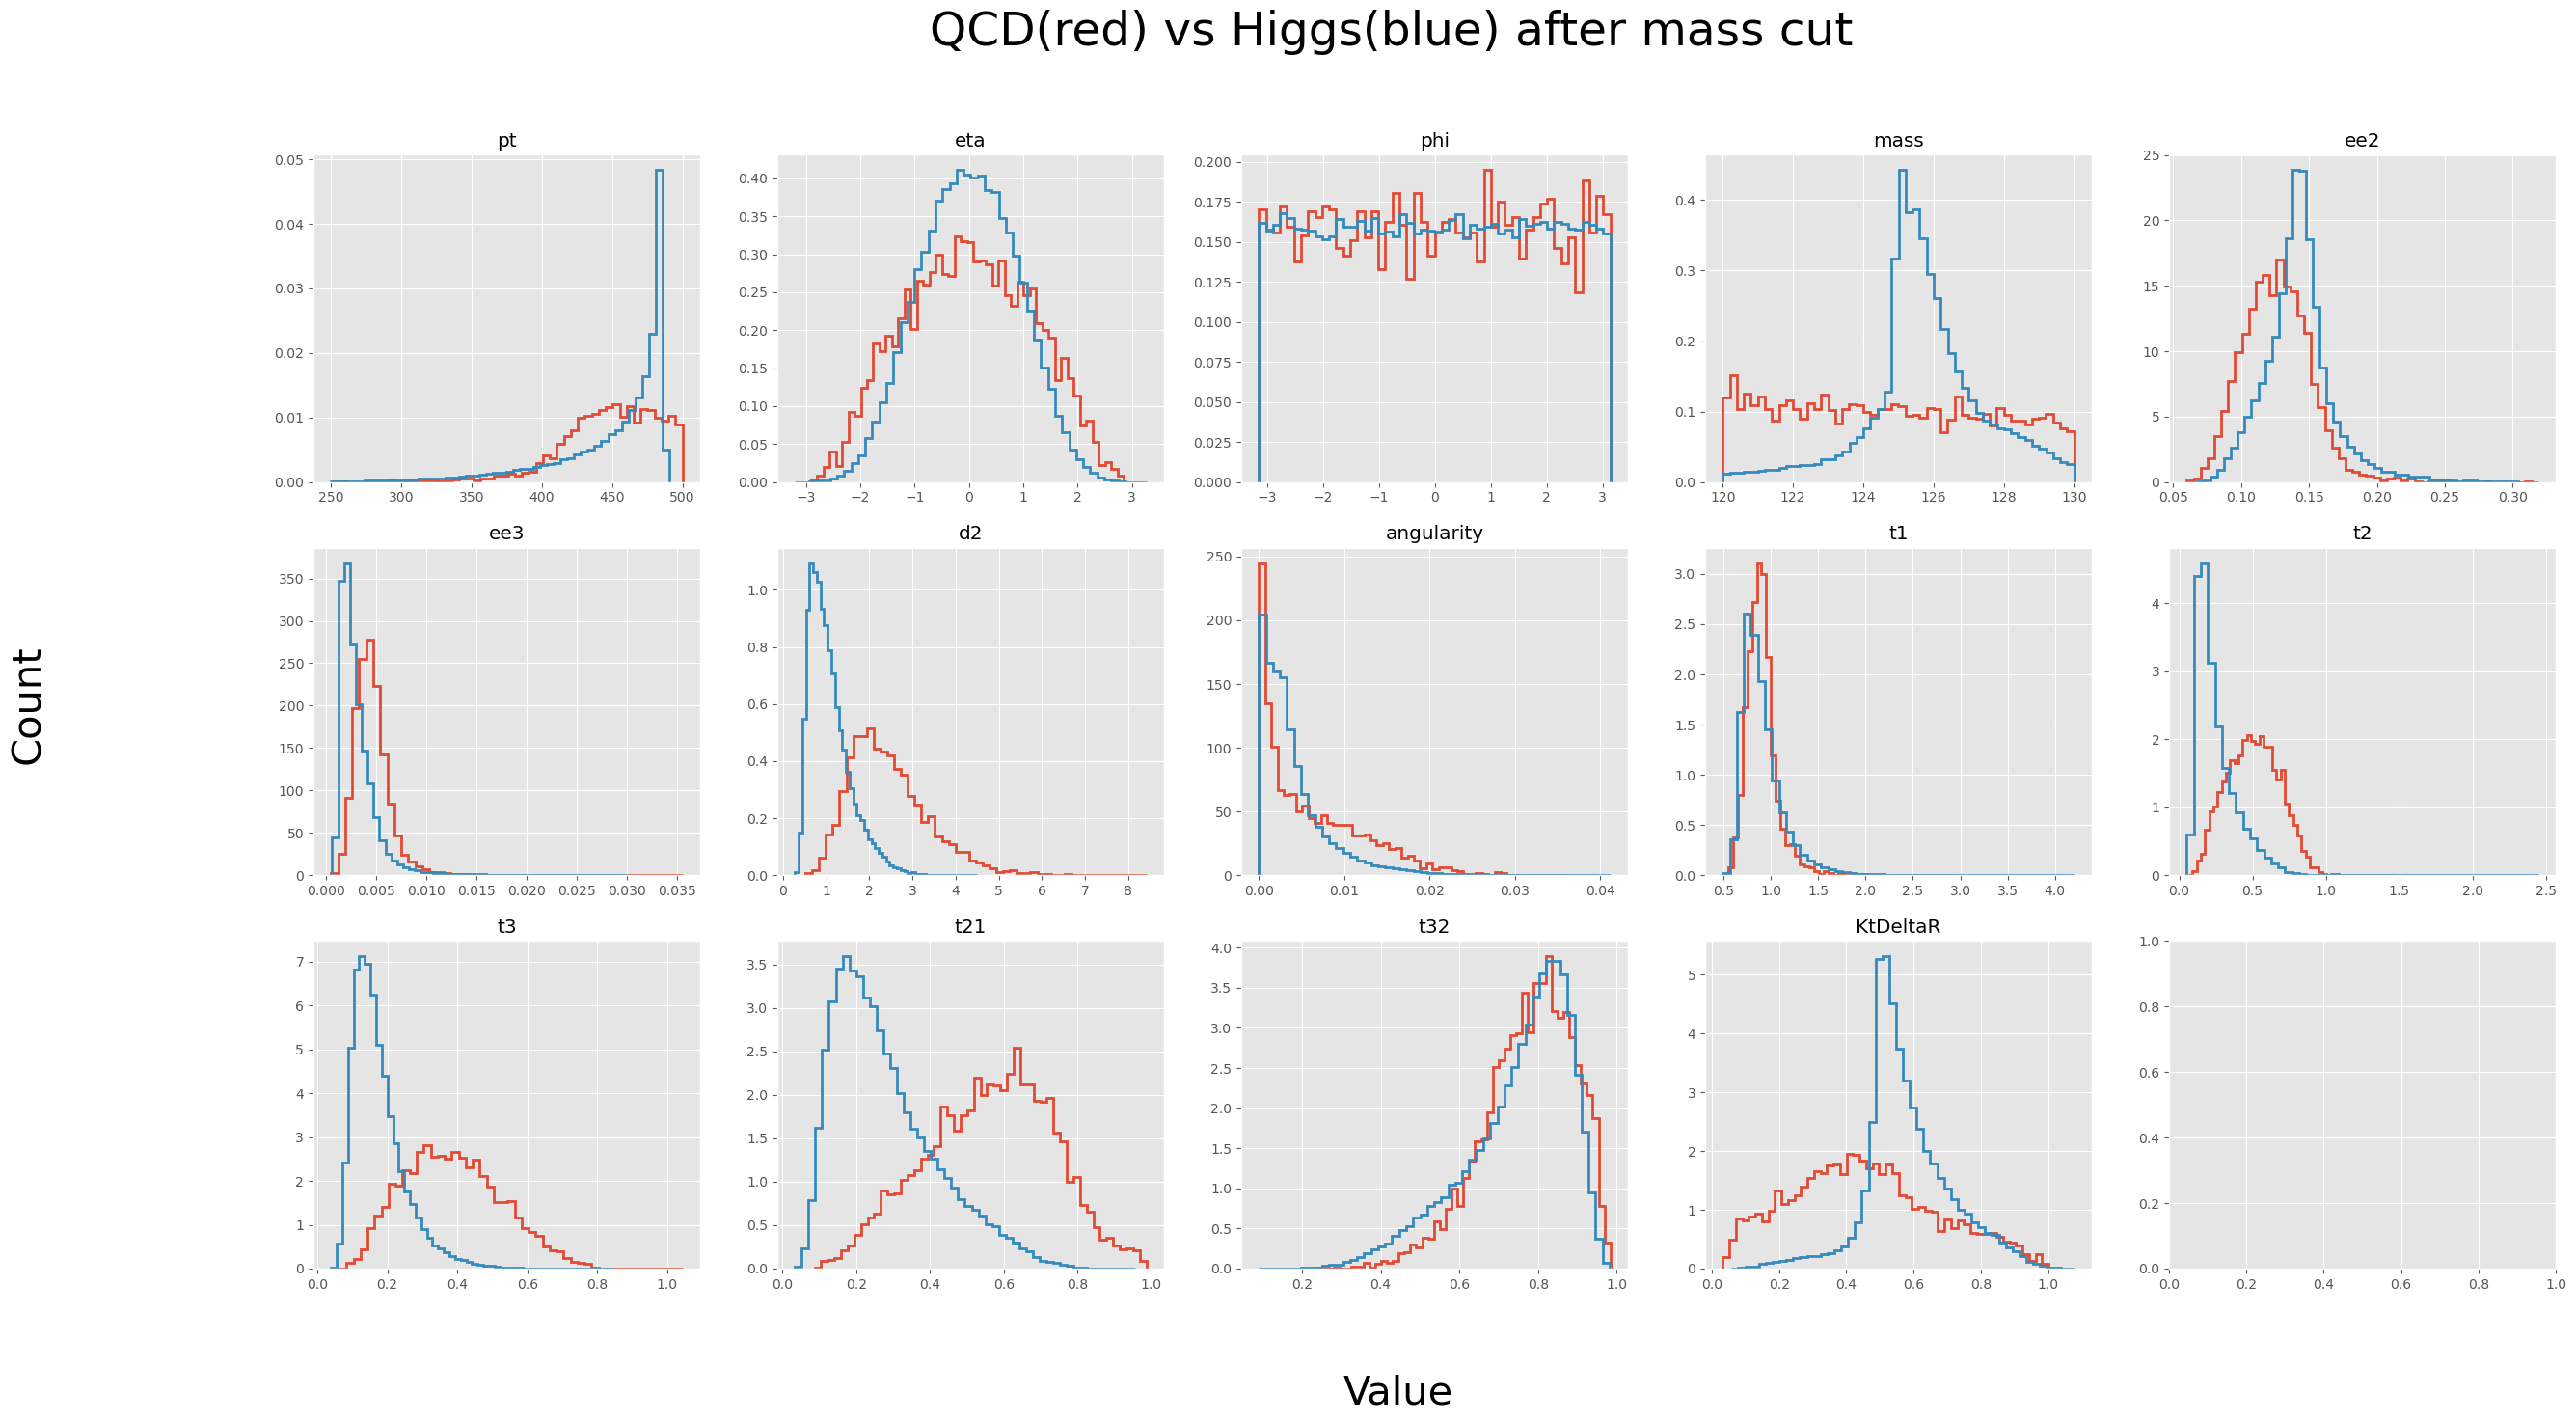

In [14]:
plt.rcParams["figure.figsize"] = (30,15)

fig, ax = plt.subplots(3,5)
bin_Size = 50
fig.suptitle('QCD(red) vs Higgs(blue) after mass cut ', fontsize = 35)
fig.supxlabel('Value',fontsize = 30)
fig.supylabel('Count',fontsize = 30)

for i, val in enumerate (keys):
    ax_x = int(i/5)
    ax_y = i%5
    ax[ax_x,ax_y].hist(qcd_mass_cut[val], histtype='step',density=True,bins = bin_Size, linewidth = 2)
    ax[ax_x,ax_y].hist(higgs_mass_cut[val], histtype='step',density=True,bins = bin_Size, linewidth = 2)
    ax[ax_x,ax_y].set_title('{}'.format(val));

After the mass cut, the most significant features for seperating the  
two datasets are: d2, t2, t3, t21 and KtDeltaR, with t21 being the best option.  
Attemping cuts:

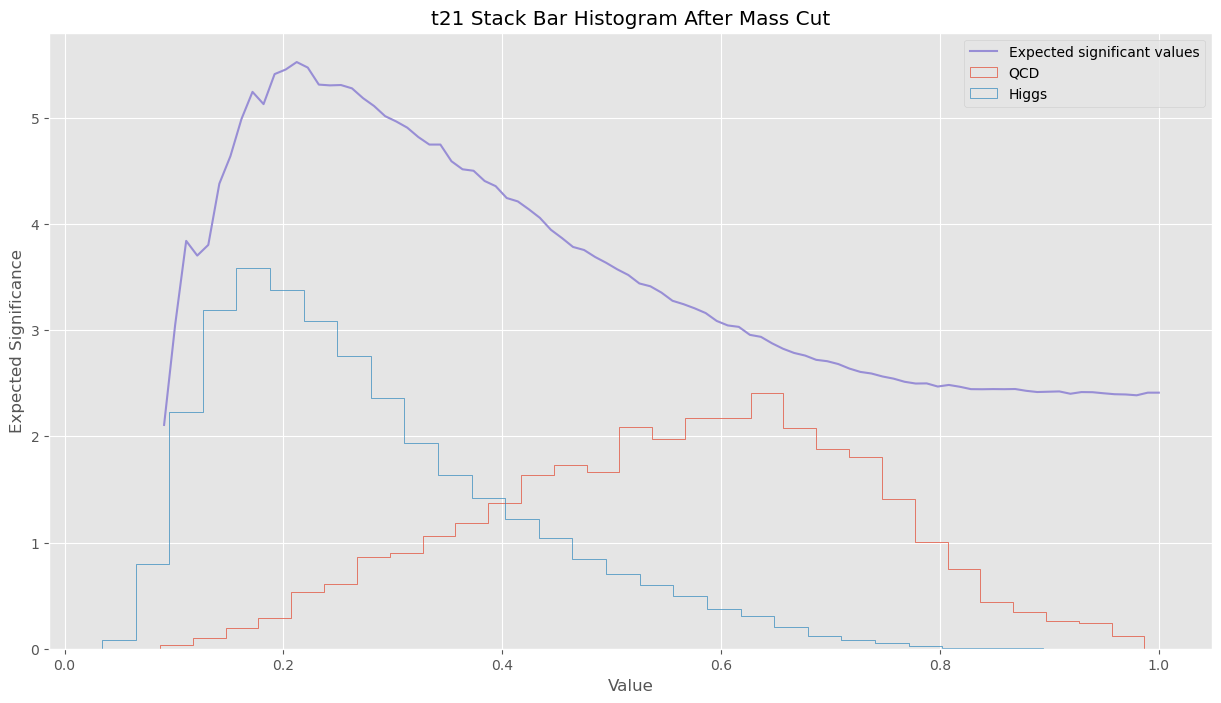

In [15]:
x_val = np.linspace(0,1,100)
y_val = []
for i in x_val:
    y_val.append(cut2(qcd_mass_cut,higgs_mass_cut,'t21',i,0, False)[2])
plt.rcParams["figure.figsize"] = (15,8)

fig, ax = plt.subplots(1,1)

ax.hist(qcd_mass_cut["t21"], 30, histtype='step',density=True, stacked=True, label = "QCD")
ax.hist(higgs_mass_cut["t21"], 30, histtype='step', density=True, stacked=True, label = "Higgs")
ax.plot(x_val,y_val, label = "Expected significant values")
ax.set_title('t21 Stack Bar Histogram After Mass Cut');
ax.set_xlabel('Value')
ax.set_ylabel('Expected Significance')
ax.legend();

In [16]:
r = cut2(qcd_mass_cut,higgs_mass_cut,'t21',0.21,0)

After the cut, N_Higgs = 28.749, N_QCD = 19.4
The expected significance is: 5.57 sigma


As shown above, the best cut is around x < 0.21, with total expected significance around 5.57

#### Bonus:

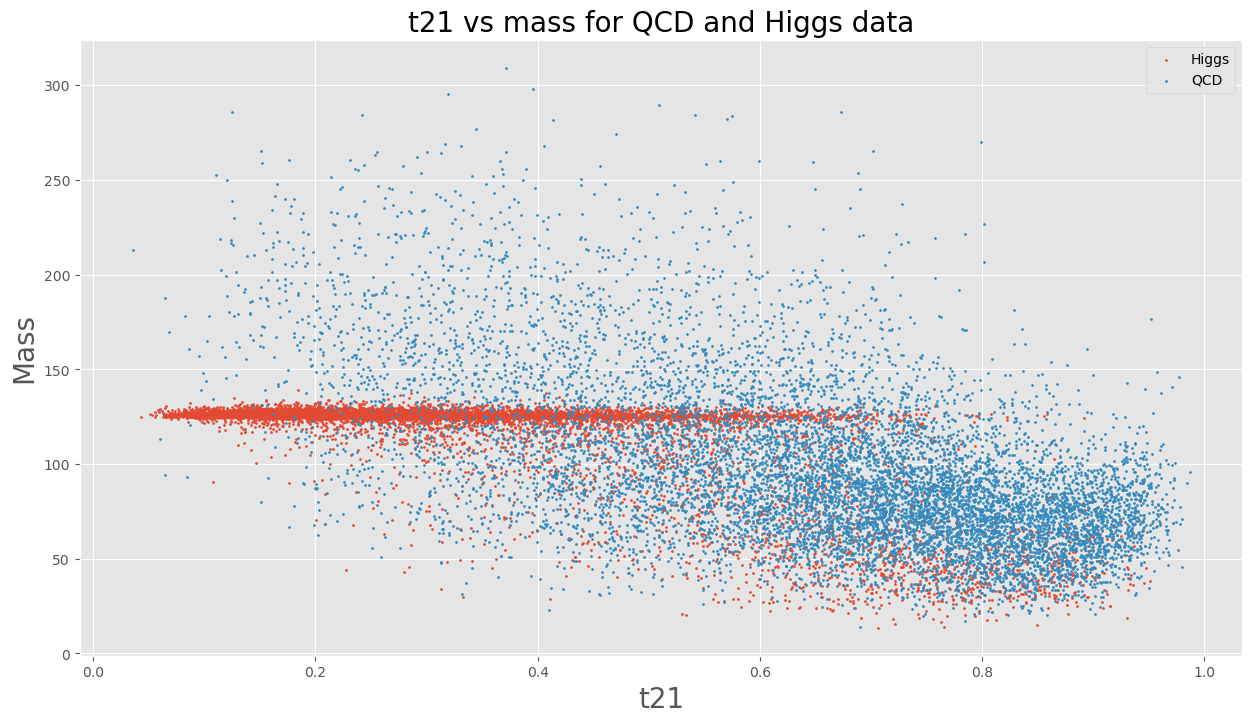

In [17]:
plt.rcParams["figure.figsize"] = (15,8)

fig, ax = plt.subplots(1,1)
bin_Size = 30
ax.scatter(higgs_dic['t21'][:10000],higgs_dic['mass'][:10000],label = "Higgs", s = 2)
ax.scatter(qcd_dic['t21'][:10000],qcd_dic['mass'][:10000], label = "QCD", s = 2)
ax.set_title('t21 vs mass for QCD and Higgs data', fontsize = 20)
ax.set_xlabel("t21", fontsize = 20)
ax.set_ylabel("Mass", fontsize = 20)
ax.legend();

The mass cut is giving almost the best sensitivity.

### Lab 8:  

In [18]:
data_high_lum = pd.read_hdf('dati/high_lum_250_500.h5') 
data_low_lum = pd.read_hdf('dati/low_lum_250_500.h5') 

#### 1)  

From lab 7, the event selection was mass cut at 120< x < 130,    
and t21 cut at x < 0.23

|      | Higgs | QCD |  
| ----------- | ----------- | ----------- |  
|  Original  |  10^5    | 10^5  |  
| Expected Yield  | 100     | 20000 |  
| ~with Event Selection  | 28.749    | 19.4 |

##### For high luminousity data:

In [48]:
expected_mass1 = np.append(qcd_dic['mass'],higgs_dic['mass'])
expected_t211 = np.append(qcd_dic['t21'],higgs_dic['t21'])
temp_q = np.full_like(qcd_dic['mass'], 200)
temp_h = np.full_like(higgs_dic['mass'], 1)
scale_f = len(data_high_lum)/ (np.sum(temp_q)+np.sum(temp_h))
temp_q *= scale_f
temp_h *= scale_f
weight_array1 = np.append(temp_q,temp_h)

# 2 plots, one for each feature, and then 2 for after the mass cut
# 95% like lab 6

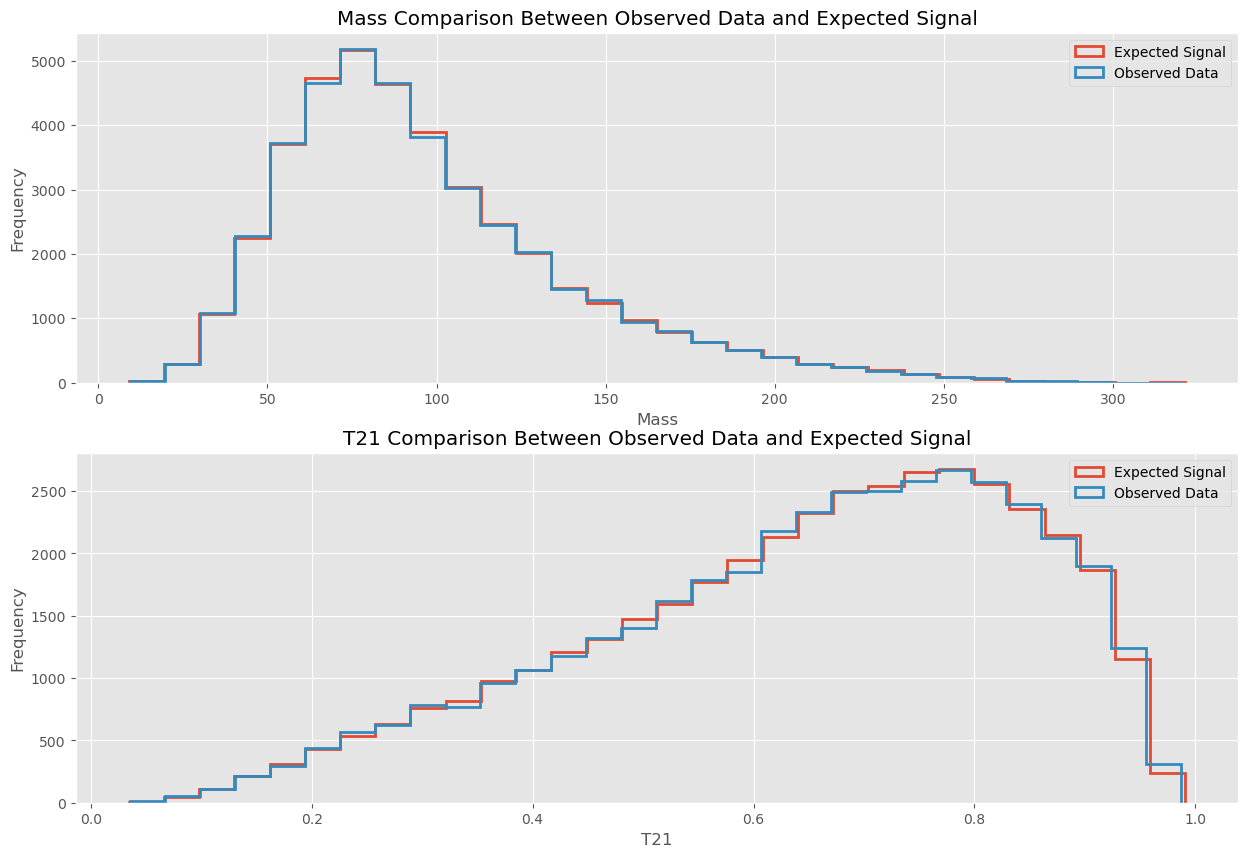

In [49]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots(2,1)
ax[0].hist(expected_mass1, 30, histtype='step',weights = weight_array1, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[0].hist(data_high_lum['mass'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[0].set_title('Mass Comparison Between Observed Data and Expected Signal');
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Frequency')
ax[0].legend();

ax[1].hist(expected_t211, 30, histtype='step',weights = weight_array1, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[1].hist(data_high_lum['t21'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[1].set_title('T21 Comparison Between Observed Data and Expected Signal');
ax[1].set_xlabel('T21')
ax[1].set_ylabel('Frequency')
ax[1].legend();

As shown, before the event selection, the expected signal is very similar to  
the observed data.

In [54]:
qcd_temp = qcd_dic[(qcd_dic['mass'] < 130) & (qcd_dic['mass'] > 120)]
higgs_temp = higgs_dic[(higgs_dic['mass'] < 130) & (higgs_dic['mass'] > 120)]

qcd_es = qcd_temp[(qcd_temp['t21'] < 0.21) & (qcd_temp['t21'] > 0)]
higgs_es = higgs_temp[(higgs_temp['t21'] < 0.21) & (higgs_temp['t21'] > 0)]

high_lum_temp = data_high_lum[(data_high_lum['mass'] < 130) & (data_high_lum['mass'] > 120)]
high_es = high_lum_temp[(high_lum_temp['t21'] < 0.21) & (high_lum_temp['t21'] > 0)]

In [50]:
expected_mass2 = np.append(qcd_es['mass'],higgs_es['mass'])
expected_t212 = np.append(qcd_es['t21'],higgs_es['t21'])
temp_q = np.full_like(qcd_es['mass'], 28.749)
temp_h = np.full_like(higgs_es['mass'], 19.4)
scale_f = len(high_es)/ (np.sum(temp_q)+np.sum(temp_h))
temp_q *= scale_f
temp_h *= scale_f
weight_array2 = np.append(temp_q,temp_h)

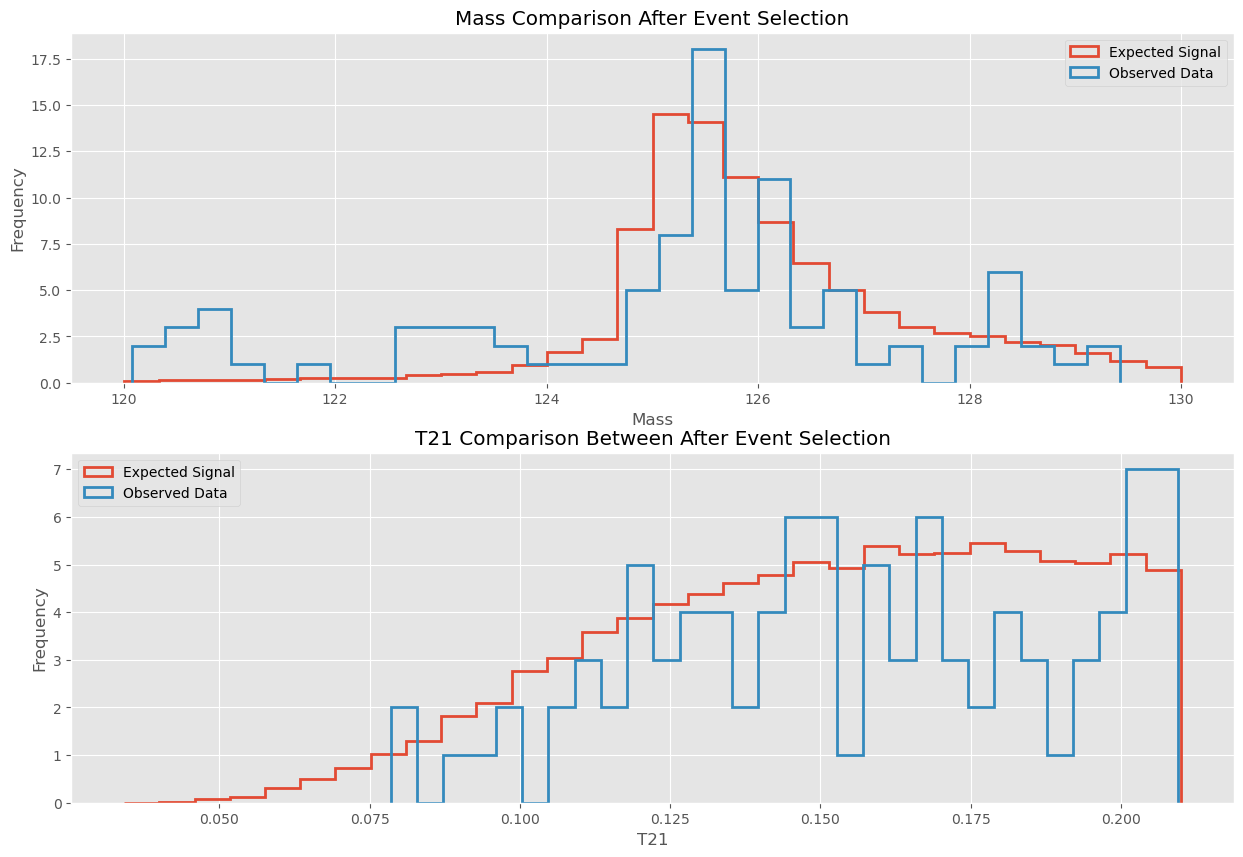

In [51]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots(2,1)
ax[0].hist(expected_mass2, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[0].hist(high_es['mass'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[0].set_title('Mass Comparison After Event Selection');
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Frequency')
ax[0].legend();

ax[1].hist(expected_t212, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[1].hist(high_es['t21'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[1].set_title('T21 Comparison Between After Event Selection');
ax[1].set_xlabel('T21')
ax[1].set_ylabel('Frequency')
ax[1].legend();

The observed signal has similar feature to that of the expected signal.  
The size of observed signal is:

In [47]:
obs_sig = len(high_es)
obs_sig

96

If the observed data is a QCD, then, the distribution should be  
a Poisson of mean:

In [52]:
qcd_sig = len(data_high_lum)*19.4/20000
qcd_sig

39.13368

Therefore, the observation significance is:

In [53]:
stats.norm.ppf(stats.poisson.cdf(obs_sig, qcd_sig))

7.733826836841

which is quite higher than the 5 $\sigma$ threshold,  
implying this is likely to be a Higgs' data.

##### For low luminousity data:

In [56]:
temp_q = np.full_like(qcd_dic['mass'], 200)
temp_h = np.full_like(higgs_dic['mass'], 1)
scale_f = len(data_low_lum)/ (np.sum(temp_q)+np.sum(temp_h))
temp_q *= scale_f
temp_h *= scale_f
weight_array1 = np.append(temp_q,temp_h)

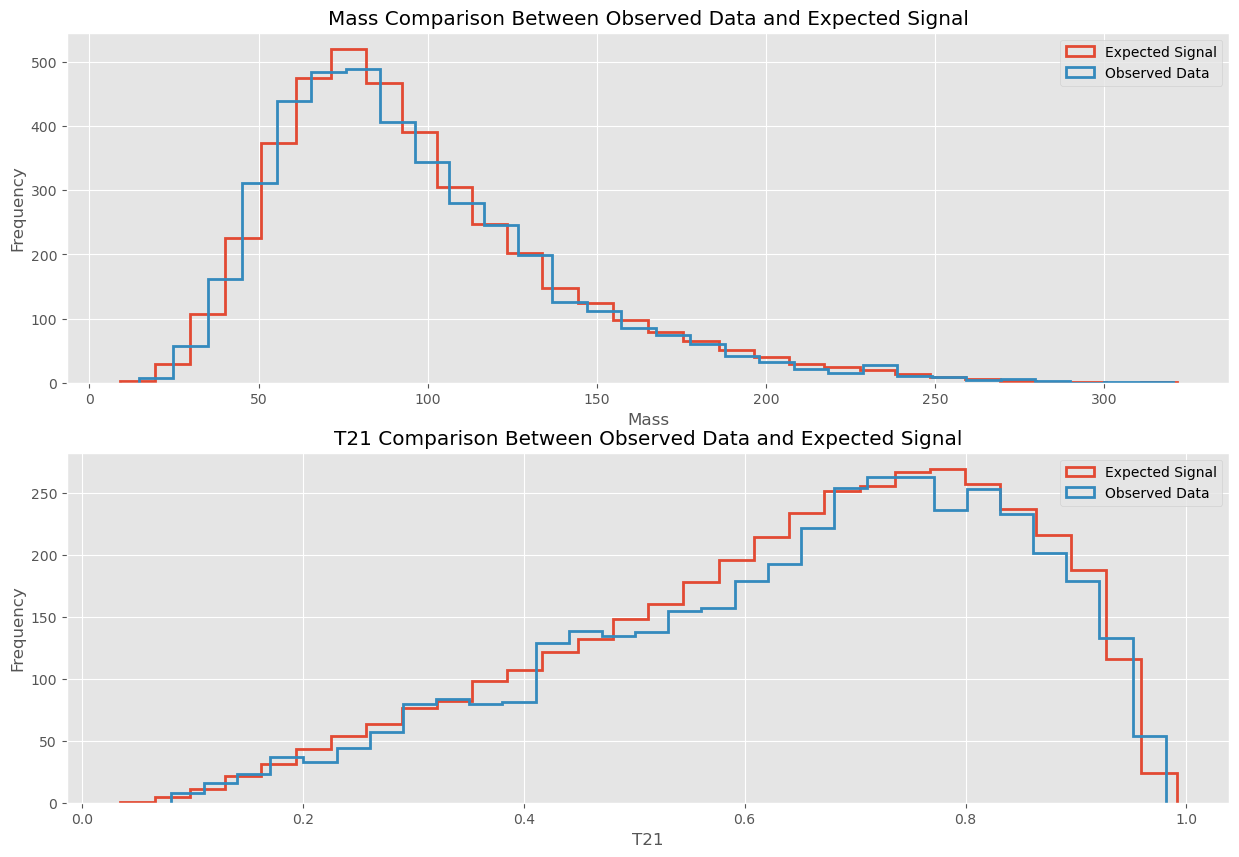

In [57]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots(2,1)
ax[0].hist(expected_mass1, 30, histtype='step',weights = weight_array1, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[0].hist(data_low_lum['mass'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[0].set_title('Mass Comparison Between Observed Data and Expected Signal');
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Frequency')
ax[0].legend();

ax[1].hist(expected_t211, 30, histtype='step',weights = weight_array1, linewidth = 2, stacked=True, label = 'Expected Signal')
ax[1].hist(data_low_lum['t21'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[1].set_title('T21 Comparison Between Observed Data and Expected Signal');
ax[1].set_xlabel('T21')
ax[1].set_ylabel('Frequency')
ax[1].legend();

In [58]:
low_lum_temp = data_low_lum[(data_low_lum['mass'] < 130) & (data_low_lum['mass'] > 120)]
low_es = low_lum_temp[(low_lum_temp['t21'] < 0.21) & (low_lum_temp['t21'] > 0)]

In [61]:
temp_q = np.full_like(qcd_es['mass'], 28.749)
temp_h = np.full_like(higgs_es['mass'], 19.4)
scale_f = len(low_es)/ (np.sum(temp_q)+np.sum(temp_h))
temp_q *= scale_f
temp_h *= scale_f
weight_array2 = np.append(temp_q,temp_h)

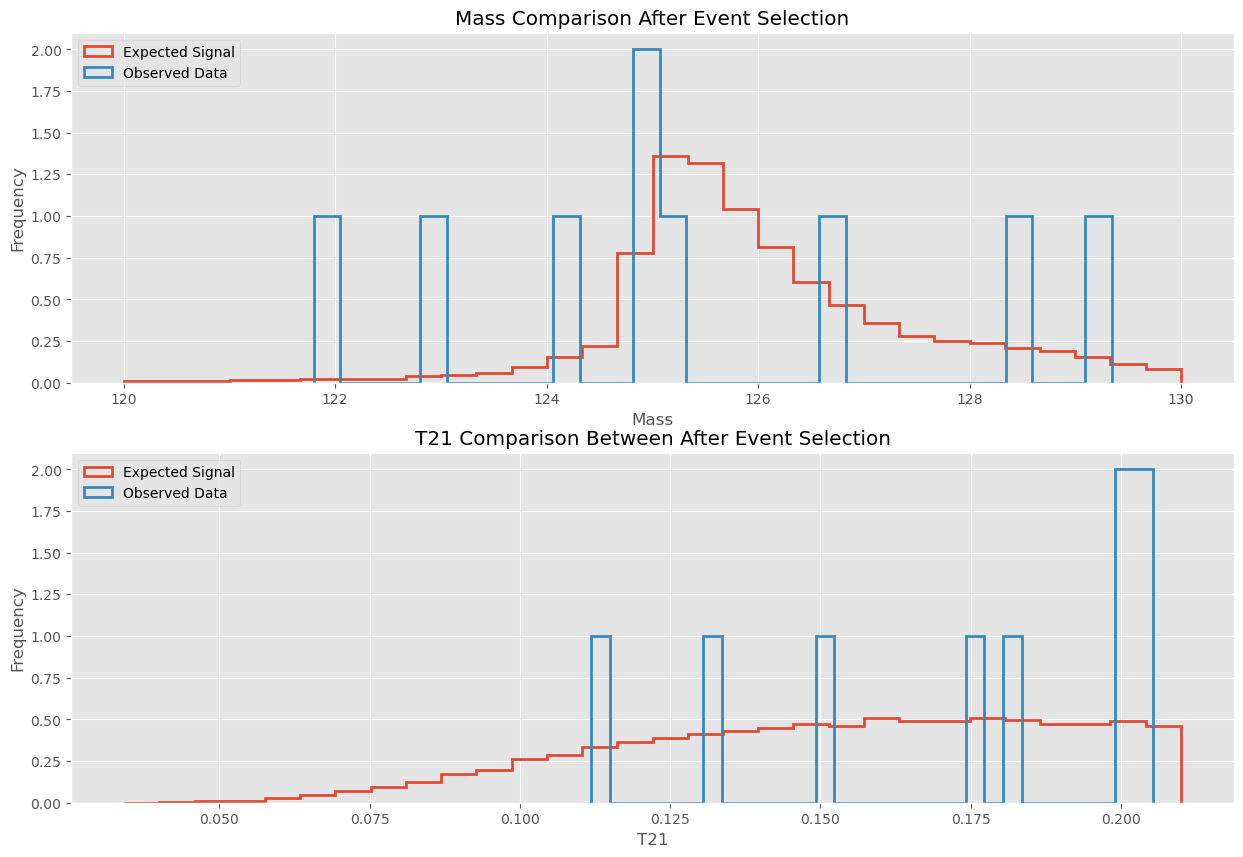

In [73]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots(2,1)
exp_n1 = ax[0].hist(expected_mass2, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
low_n1 = ax[0].hist(low_es['mass'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[0].set_title('Mass Comparison After Event Selection');
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Frequency')
ax[0].legend();

exp_n2 = ax[1].hist(expected_t212, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
low_n2 =ax[1].hist(low_es['t21'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[1].set_title('T21 Comparison Between After Event Selection');
ax[1].set_xlabel('T21')
ax[1].set_ylabel('Frequency')
ax[1].legend();

The observed data varies significantly from the expected signal,  
partly due to the low sample size of observed data:

In [67]:
obs_sig = len(low_es)
obs_sig

9

If the observed data is a QCD, then, the distribution should be  
a Poisson of mean:

In [68]:
qcd_sig = len(data_low_lum)*19.4/20000
qcd_sig

3.9382

Therefore, the observation significance is:

In [69]:
stats.norm.ppf(stats.poisson.cdf(obs_sig, qcd_sig))

2.4399022190658797

Which is less than the 5 $\sigma$ threshold,  
so we cannot claim a discovery in this case.

In [231]:
# take in an output from histogram plot,
# return 95% boundaries in [lower, upper]
def sort_95(arr):
    a = arr[0]
    array = a/sum(a)
    a_sorted = np.sort(array)[::-1]
    k = 0
    i = 0
    while k< stats.norm.cdf(2):
        k += a_sorted[i]
        i += 1
    a_s = a_sorted[:i]
    c = np.mean(arr[1])
    ans = [c,c]
    for k, val in enumerate(array):
        if (val in a_s):
            if arr[1][k] > ans[1]:
                ans[1] = arr[1][k]
            if arr[1][k] < ans[0]:
                ans[0] = arr[1][k]
    return ans

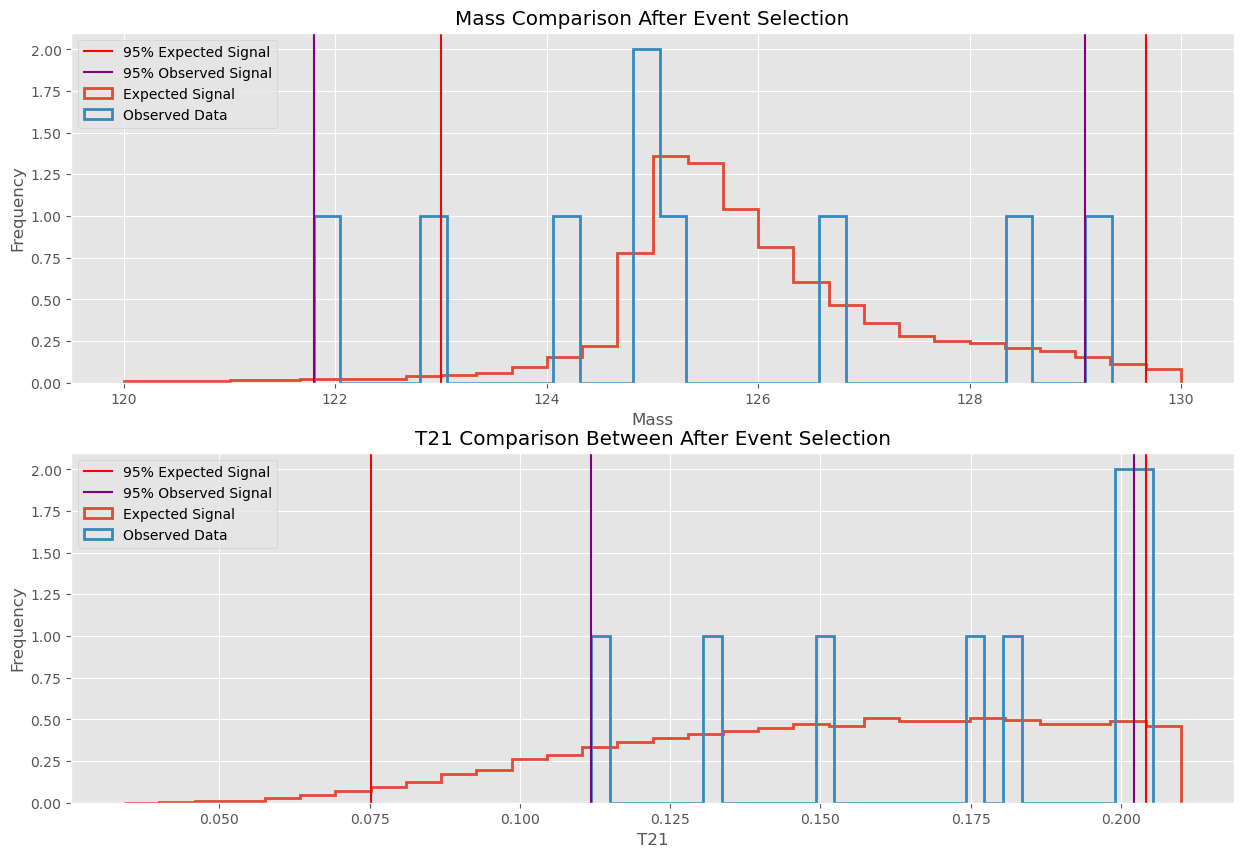

In [230]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots(2,1)
exp_n1 = ax[0].hist(expected_mass2, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
low_n1 = ax[0].hist(low_es['mass'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[0].axvline(x=sort_95(exp_n1)[0], color = 'red', label = '95% Expected Signal')
ax[0].axvline(x=sort_95(exp_n1)[1], color = 'red')
ax[0].axvline(x=sort_95(low_n1)[0], color = 'purple', label = '95% Observed Signal')
ax[0].axvline(x=sort_95(low_n1)[1], color = 'purple')
ax[0].set_title('Mass Comparison After Event Selection');
ax[0].set_xlabel('Mass')
ax[0].set_ylabel('Frequency')
ax[0].legend();

exp_n2 = ax[1].hist(expected_t212, 30, histtype='step',weights = weight_array2, linewidth = 2, stacked=True, label = 'Expected Signal')
low_n2 =ax[1].hist(low_es['t21'], 30, histtype='step',  linewidth = 2, label = 'Observed Data')
ax[1].axvline(x=sort_95(exp_n2)[0], color = 'red', label = '95% Expected Signal')
ax[1].axvline(x=sort_95(exp_n2)[1], color = 'red')
ax[1].axvline(x=sort_95(low_n2)[0], color = 'purple', label = '95% Observed Signal')
ax[1].axvline(x=sort_95(low_n2)[1], color = 'purple')
ax[1].set_title('T21 Comparison Between After Event Selection');
ax[1].set_xlabel('T21')
ax[1].set_ylabel('Frequency')
ax[1].legend();

The 95% range is graphed above.
with the T21, the expected signal has larger range than the observed data,  
while with the mass, the two are very similar.